# 0.1 Analysis on Light-outages and Crime

Garrett Eason, Chris Broll, Shilpa Rajbhandari

This project seeks to exploit a kind of natural experiment in the District of Columbia by examining crime in close proximity to street lights before and after they have been repaired.

The simplest analysis we can conceive is examining crime the week before and the week after a repair. This will require: (1) geocoding the crime data; (2) geocoding lighting data; (3) drawing a circle 1/4th of a city block around each light; (4) joining the lighting polygons with the crime data surrounding each light for the week prior to and following the repair. More sophisticated analyses will include standard statistical analyses and, possibly, machine learning analyses to predict where improved or upgraded lighting could do the most good.


## Initial Hypothesis:
Crimes committed at night will have a higher probability of occurring when a streetlight is out.

## Methods:

We will begin by considering geocoded lighting data (provided in 0.0a and 0.0b), where each light out is mapped to the surrounding reported night crimes within approximately 1/4th of a city block radius, e.g. .000625 Maryland coordinate units (regardless of time).  Then we will consider the subset of light posts that have had night crimes mapped to them, distinguishing a better comparison across light outs that are in areas with some demonstrated probability of a crime occuring.  This approach will cause our estimates to be larger in magnitude and should be considered if economically relevant findings are present.  Then we will differentiate night crimes that have occurred within a 10-day time frame of the remaining lightoutages.  Finally, using all this informaiton, we will conduct a simple difference in means analysis to potentially motivate further research into this hypothesis.

In [4]:
#%% Packages
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

#%pylab notebook
#pylab.rcParams['figure.figsize'] = (12, 12)
%matplotlib notebook
plt.rcParams["figure.figsize"] = [9, 8]

#%% Locations
Windows = 'C:/Users/Sade/Documents/GitHub/lights-and-crime/Lights and Crime Garrett/Data'
Linux = '/home/sade/Desktop/Git Cloned Repos/lights-and-crime/Lights and Crime Garrett/Data'

choice = Windows

*Note:* make sure to point "choice" to the location of "Data" in repository on your computer.

## Basic EDA
### Data
* Crimes - Data set about crimes (see 0.0a).<br>
* Lights - Data set about light outages (see 0.0b).<br>
* iSlims - Older data set containing information regarding public work (including light outages) (see 0.0a).<br>
* fc - Data set containing failure codes for iSlims and City Work data (see 0.0a).<br>
* geoLights0 - Lights mapped to night crimes outside 10 day before and after window (used to compare lightoutages in areas where crime occurance has some probability (see 0.0b).<br>
* geoLights1 - Lights mapped to night crimes inside 10 day before and after window (see 0.0b).<br>
* geoDLights0 - same as geoLights0 but for day hours.
* geoDLights1 - same as geoLights1 but for day hours.
* Street_Lights - Data on street lights in the district (from: http://opendata.dc.gov/datasets/street-lights ).<br>

In [2]:
#%% EDA Data
Crimes = pd.read_excel(choice + '/crimes.xlsx')
iSlims = pd.read_excel(choice + '/iSlims_final.xlsx')
fc = pd.read_excel(choice + '/islims_failure_codes.xlsx')

### EDA iSlims
*Note:* EDA of CityWork data not done here, but the CityWork data is included in the analysis.

In [3]:
iSlims[['daysToComplete', 'daysLate']].describe()

,daysToComplete,daysLate
count,178337.000000,178337.000000
mean,2.064552,0.092875
std,2.366900,0.766011
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,0.000000
max,23.000000,17.000000


On average it takes 2 days to complete a task and the completion of tasks are rarely late (excluding completion tasks beyond 14 days).


In [4]:
iSlims['ProblemID'].value_counts().head(5)

2      173121
13       1273
433       697
430       562
196       489
Name: ProblemID, dtype: int64

In [5]:
c = [2, 13, 433, 430, 196]
for i in range(len(fc)):
    if fc.loc[i,'failcodeID'] in c:
        print(str(fc.loc[i,'failcodeID']) + ' Description: ' +fc.loc[i, 'description'])

2 Description: (Light out)
13 Description: (No current)
196 Description: (Underpass light out)
430 Description: (DDOT Refer)
433 Description: (No Current to Over Head)


The vast majority of observation fail codes are lights going out as can be seen by the top 5 counts of failure codes.

<IPython.core.display.Javascript object>


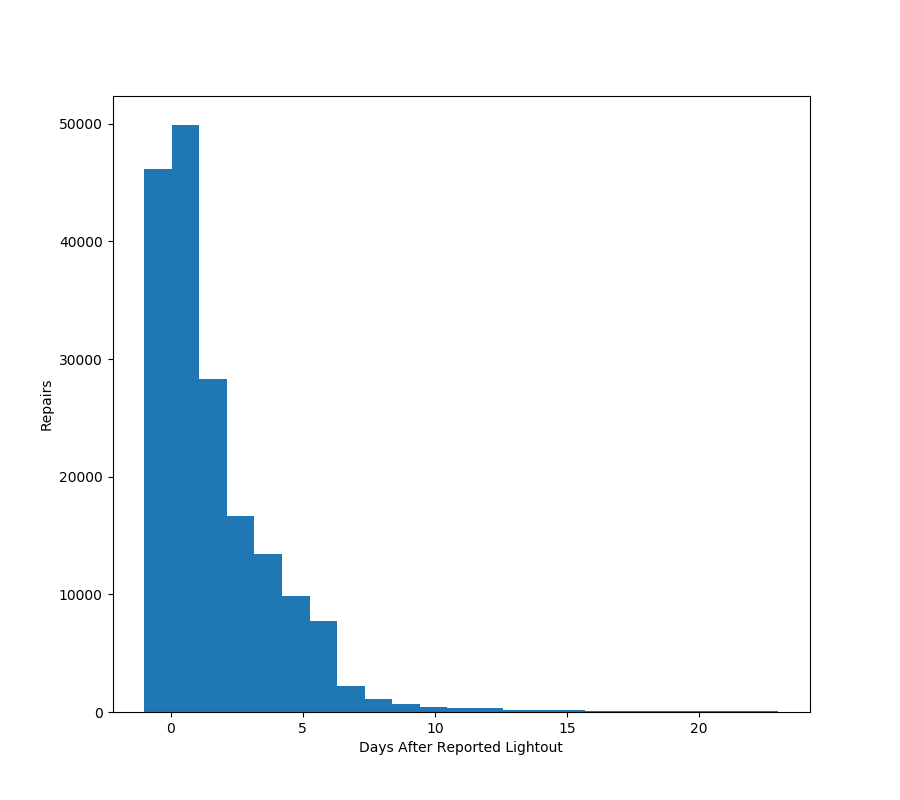

Text(0,0.5,'Repairs')

In [8]:
plt.figure(1)
plt.hist(iSlims['daysToComplete'], bins = 23)
plt.xlabel('Days After Reported Lightout', fontsize=10)
plt.ylabel('Repairs', fontsize=10)

Histogram of the days it took to complete a work order.  As expected we can see a large drop off after 5 days.

<IPython.core.display.Javascript object>


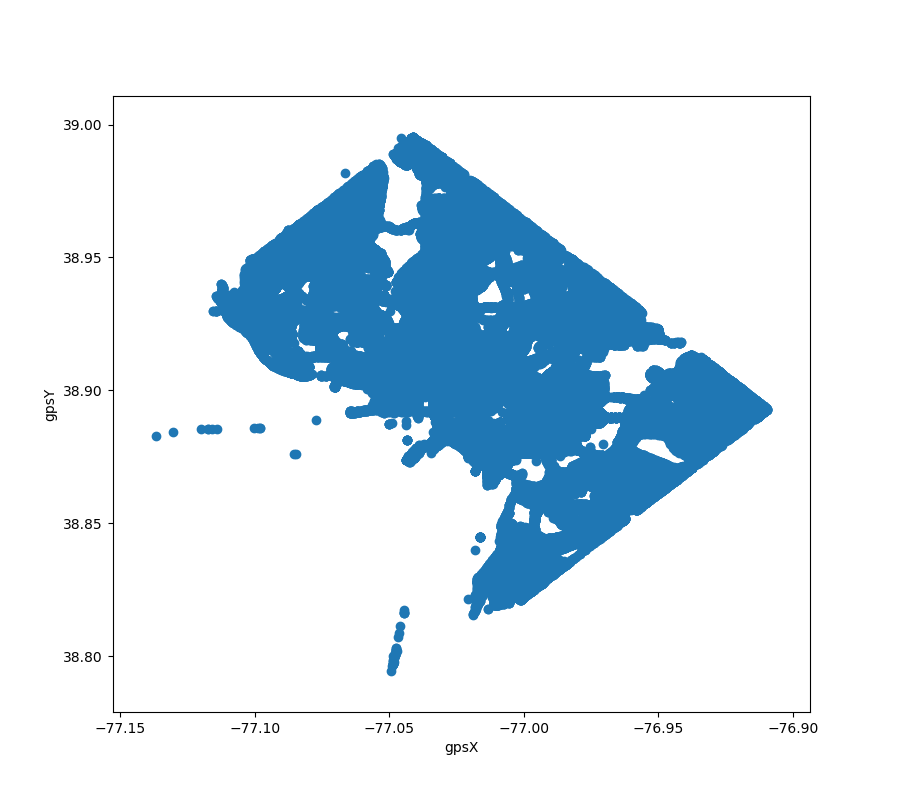

Text(0,0.5,'gpsY')

In [9]:
plt.figure(2)
plt.scatter(iSlims['gpsX'], iSlims['gpsY'])
plt.xlabel('gpsX', fontsize=10)
plt.ylabel('gpsY', fontsize=10)

As we can see it looks like the location data is plausible.

### EDA Crime

Taking a look at several variables in the Crimes data set:

In [16]:
Crimes[['SHIFT', 'METHOD', 'OFFENSE']].describe()
for i in ['SHIFT', 'METHOD', 'OFFENSE']:
    print(i + ':',Counter(Crimes[i]))

SHIFT: Counter({'EVENING': 120273, 'DAY': 108579, 'MIDNIGHT': 53042})
METHOD: Counter({'OTHERS': 256577, 'GUN': 16118, 'KNIFE': 9199})
OFFENSE: Counter({'THEFT/OTHER': 102156, 'THEFT F/AUTO': 82599, 'ROBBERY': 27559, 'BURGLARY': 24257, 'MOTOR VEHICLE THEFT': 23669, 'ASSAULT W/DANGEROUS WEAPON': 18311, 'SEX ABUSE': 2186, 'HOMICIDE': 942, 'ARSON': 215})


<IPython.core.display.Javascript object>


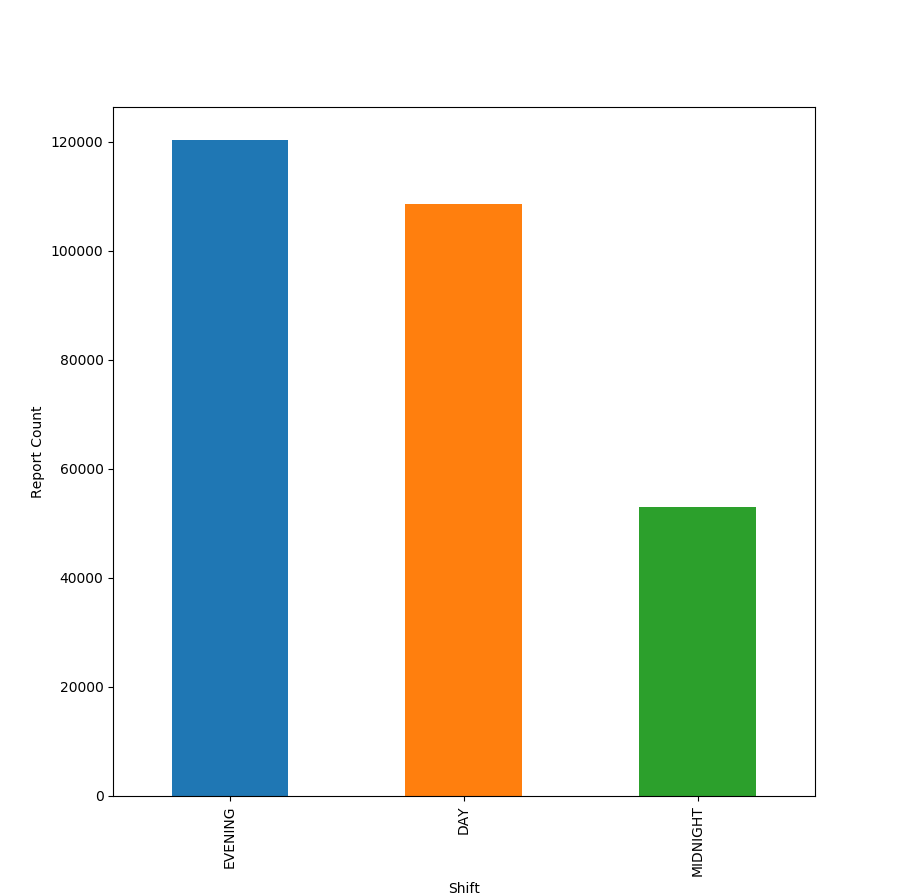

Text(0,0.5,'Report Count')

In [12]:
plt.figure(3)
Crimes['SHIFT'].value_counts().plot(kind='bar')
plt.xlabel('Shift', fontsize=10)
plt.ylabel('Report Count', fontsize=10)

The fewest crimes take place during the "MIDNIGHT" shift.

<IPython.core.display.Javascript object>


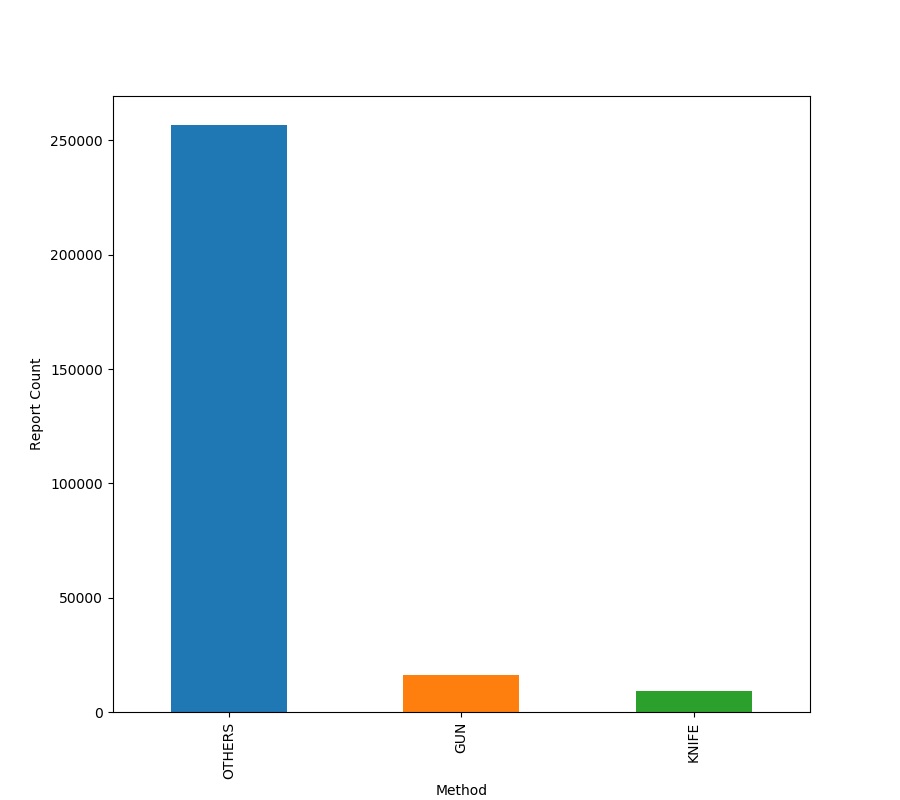

Text(0,0.5,'Report Count')

In [13]:
plt.figure(4)
Crimes['METHOD'].value_counts().plot(kind='bar')
plt.xlabel('Method', fontsize=10)
plt.ylabel('Report Count', fontsize=10)

<IPython.core.display.Javascript object>


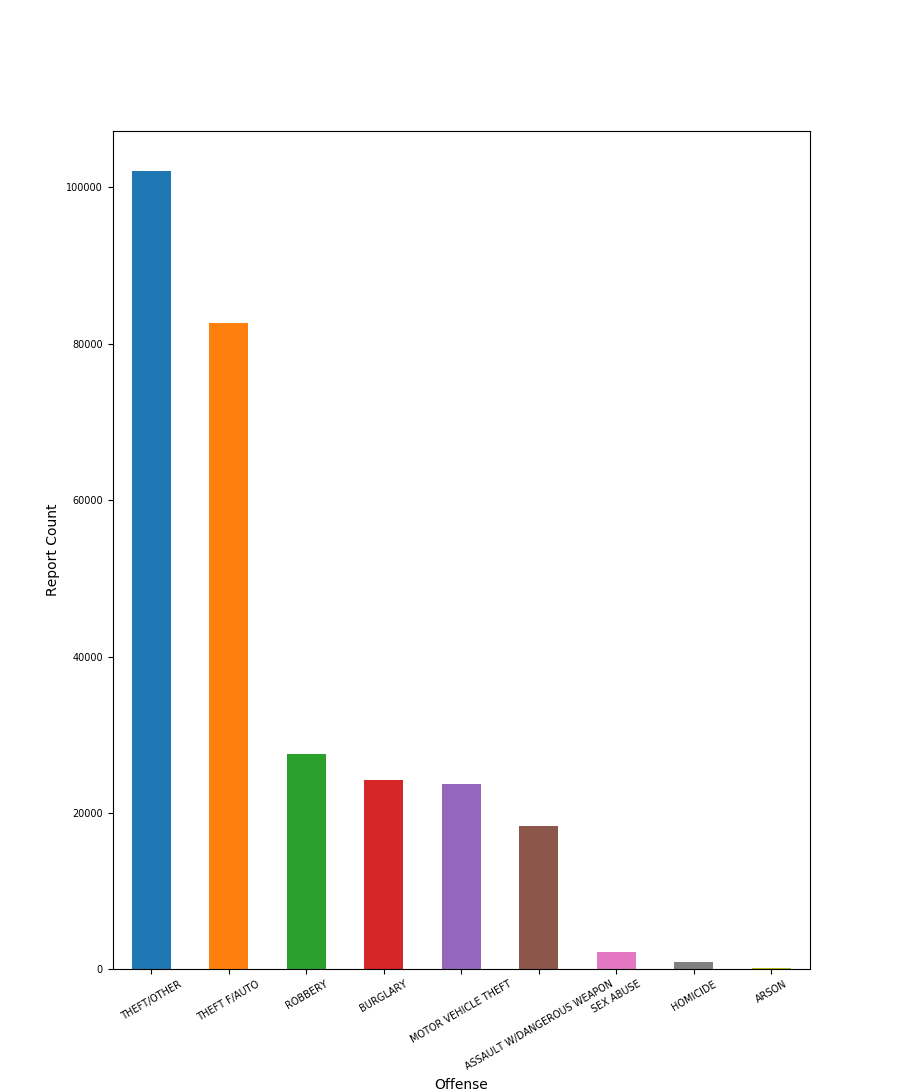

Text(0,0.5,'Report Count')

In [14]:
plt.figure(5)
Crimes['OFFENSE'].value_counts().plot(kind='bar', rot=30, fontsize=7)
plt.xlabel('Offense', fontsize=10)
plt.ylabel('Report Count', fontsize=10)

Most crimes involve theft.

<IPython.core.display.Javascript object>


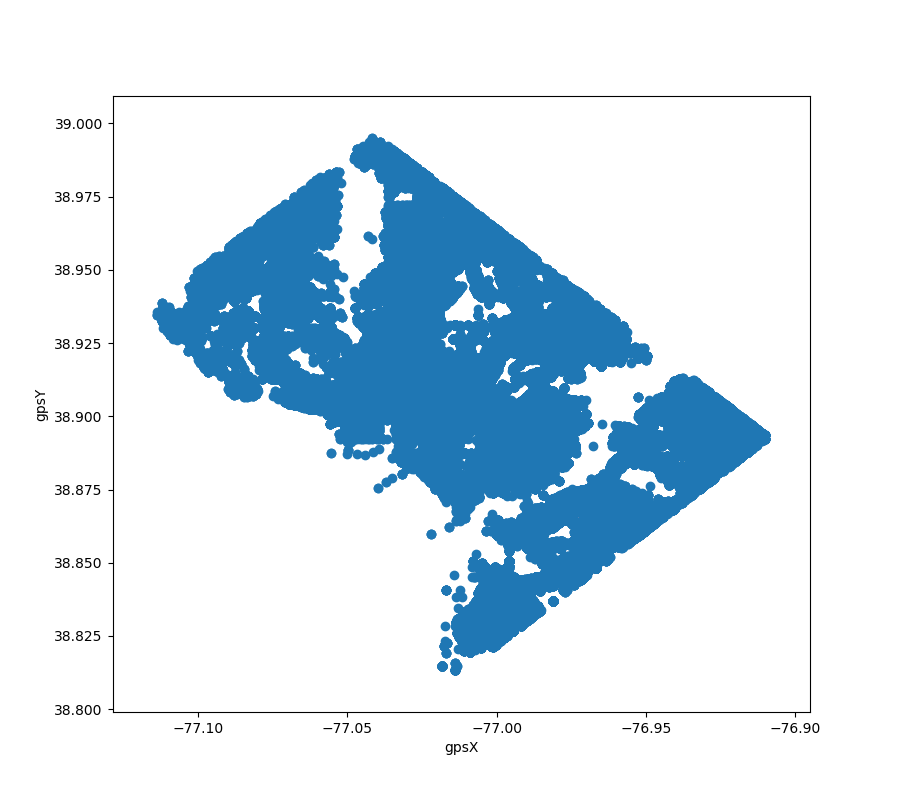

Text(0,0.5,'gpsY')

In [15]:
plt.figure(6)
plt.scatter(Crimes['X'], Crimes['Y'])
plt.xlabel('gpsX', fontsize=10)
plt.ylabel('gpsY', fontsize=10)

Again the Location data looks plausible.

<IPython.core.display.Javascript object>


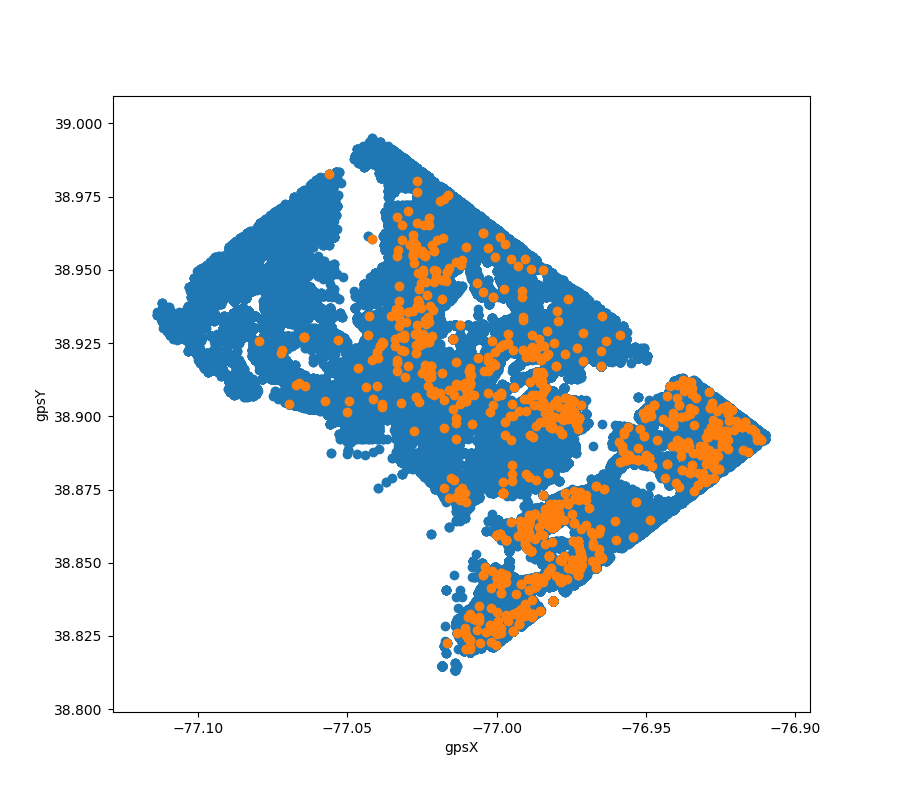

Text(0,0.5,'gpsY')

In [16]:
plt.figure(7)
plt.scatter(Crimes['X'], Crimes['Y'])
plt.scatter(Crimes[Crimes['OFFENSE'] == 'HOMICIDE']['X'], Crimes[Crimes['OFFENSE'] == 'HOMICIDE']['Y'])
plt.xlabel('gpsX', fontsize=10)
plt.ylabel('gpsY', fontsize=10)

Map of Homicides layed over all other criminal activities.  Homicides are disproportionately located on the Eastern side of DC and away from major federal buildings.

## Final Data Cleaning
We start by loading our three main data sets, these include: "Lights.xlsx" - a data set with all the lightoutages (iSlims + CityWork data), "geoLights0.xlsx" - a data set that includes all the light-outages merged with crimes in a 1/4th block radius (1/2 a block diameter) that did not happen in a 20 day (10 days before repair and 10 days after repair) window, and "geoLights1.xlsx" - a data set that includes all the light-outages merged with crimes in a 1/4th block radius that did happen in a 20 day window.

After loading our data we do one final quick cleaning and manipulate our "geoLights1.xlsx" into two new data sets. For the "L_yesCR_dup_only" data set, we pull out all the instances of multiple crimes being mapped to a single street light outage. For the "L_yesCR_nodup" data set, we map all multiple instances.


In [19]:
# Setting up geo joined data 
# geoLights0 is a df of light outages and crimes that did not happen in a 10 day window
# geoLights1 is a df of light outages and crimes that happened in a 10 day window
Lights = pd.read_excel(choice + '/Lights.xlsx')
Lights = Lights[~Lights.duplicated(['WoID'], keep = False)] # Removing Incorrectly valued work orders (1606 observations).  Take note of this because this is still useful information!
L_noCR = pd.read_excel(choice + '/geoLights0.xlsx')
L_noCR = L_noCR.reset_index(drop = True)
L_yesCR_dup = pd.read_excel(choice + '/geoLights1.xlsx')
L_yesCR_dup = L_yesCR_dup.reset_index(drop = True)
# Be advised there is some small cross over between L_noCR and L_yesCR_dup

# Pulling out all the duplicate crimes into a side dataframe
L_yesCR_dup_only = L_yesCR_dup[L_yesCR_dup.duplicated(['WoID'], keep = False)]
L_yesCR_dup_only = L_yesCR_dup_only.reset_index(drop = True)

# Making a data set that treats multiple crimes at the same time/ place as one
L_yesCR_nodup = L_yesCR_dup[~L_yesCR_dup.duplicated(['WoID'], keep = 'first')]
L_yesCR_nodup = L_yesCR_nodup.reset_index(drop = True)
#L_temp = L_yesCR_dup[~L_yesCR_dup.duplicated(['WoID'], keep = False)]
#L_yesCR_nodup = pd.concat([L_yesCR_dup_1st, L_temp])

#%% Merging and setting up final dataset

# Pulling out unmatched observations
L_0_1 = pd.concat([L_noCR, L_yesCR_nodup]) # With overlap
L_temp = L_0_1[L_0_1.duplicated(['WoID'], keep = False)]
L_0_1 = L_0_1[~L_0_1.duplicated(['WoID'], keep = False)]
L_temp = L_temp[L_temp['Crime_LO_intime'] == 1]
L_0_1 = pd.concat([L_0_1, L_temp]) # Without overlap

# Final dataset
L_full = pd.merge(Lights, L_0_1, how = 'left', on = 'WoID')
L_full = L_full.drop(['WoEntered_y', 'WoCompleted_y', 'gpsX_y', 'gpsY_y'], axis = 1)
L_full = L_full.rename(columns={'gpsX_x':'gpsX', 'gpsY_x':'gpsY', 'WoEntered_x':'WoEntered', 'WoCompleted_x':'WoCompleted', 'X':'gpsX_CR', 'Y':'gpsY_CR'})
L_full['Crime_LO_intime'][np.isnan] = 0

/home/sade/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### To Excel

In [5]:
L_yesCR_dup_only.to_excel(choice + '/Rampage.xlsx')
L_full.to_excel(choice + '/Final_Lights.xlsx')

## Results: Difference in Means Analysis
*Note:* This analysis consists of a geojoin between crime data sets from 2010-2017 and both the iSlims data and CityWork data.<br>
Splitting the crimes into before and after 10 day categories (*Note:* 1 day buffer to avoid category errors):

In [6]:
L_full['CR_Before_Fix'] = 0
for i in L_full[L_full['Crime_LO_intime'] == 1].index:
    if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days <= 10:
        L_full.loc[i, 'CR_Before_Fix'] = 1
L_full['CR_After_Fix'] = 0
for i in L_full[L_full['Crime_LO_intime'] == 1].index:
    if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days < 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= -10:
        L_full.loc[i, 'CR_After_Fix'] = 1

Total observed light outs tied with crimes out of our sample before the repair:

In [24]:
sum(L_full['CR_Before_Fix'])

2575

Total observed light outs tied with crimes out of our sample after the repair:

In [25]:
sum(L_full['CR_After_Fix'])

2365

Because we will only consider the binary crime(s) took place or not, we can consider the following means as differences in probabilities.<br>
Estimates are based on 10 "days out".<br>
Unconditional difference in means: E[u]-E[t]<br>

In [298]:
meandif = sum(L_full['CR_Before_Fix'])/len(L_full) - sum(L_full['CR_After_Fix'])/len(L_full)
meandif

0.00115111383967725

Difference in Probability: approximately 0.12 percentage points

*Note:*<br>
<br>
For a Binary Random Variable:<br>
Var(x) = E[x^2] - E[x]^2<br>
        = E[x]   - E[x]^2, remember x = 1 or 0<br>
        = P(x = 1) - P(x = 1)^2<br>
        = P(x = 1)(1 - P(x = 1))<br>
<br>
For the sample standard deviation between two means:<br>
S(m1-m2) = sqrt([S1^2/n1] - [S2^2/n2])


In [27]:
VarB = sum(L_full['CR_Before_Fix'])/len(L_full)*(1 - sum(L_full['CR_Before_Fix'])/len(L_full))
VarA = sum(L_full['CR_After_Fix'])/len(L_full)*(1 - sum(L_full['CR_After_Fix'])/len(L_full))
Sdif = np.sqrt((VarB/len(L_full))+(VarA/len(L_full)))
t = meandif/Sdif
t

3.008301154300947

P-value is approximately 0; estimate is statistically significant.<br>
This evidence supports the conculsion that light outages do affect crime generally by a very small margin unconditionally.<br>
Given the magnitude of our esitmate, it is likely that light outages do not effect crime economically.<br>
However, it should be stated that the percentage change in probability works out to be approximately 8.5%.  Therefore, if a lightbulb is replaced there is an 8.5% reduction in crime occurrance probability.

Conditional difference in means: E[u|'Lightout&CR' = 1] - E[t|'Lightout&CR' = 1]

In [299]:
meandif_cond = sum(L_full['CR_Before_Fix'])/sum(L_full['Crime_LO_intime']) - sum(L_full['CR_After_Fix'])/sum(L_full['Crime_LO_intime'])
meandif_cond

0.04019908116385906

Difference in Probability: approximately 4 percentage points

In [300]:
VarB = sum(L_full['CR_Before_Fix'])/sum(L_full['Crime_LO_intime'])*(1 - sum(L_full['CR_Before_Fix'])/sum(L_full['Crime_LO_intime']))
VarA = sum(L_full['CR_After_Fix'])/sum(L_full['Crime_LO_intime'])*(1 - sum(L_full['CR_After_Fix'])/sum(L_full['Crime_LO_intime']))
Sdif = np.sqrt((VarB/sum(L_full['Crime_LO_intime']))+(VarA/sum(L_full['Crime_LO_intime'])))
t = meandif_cond/Sdif
t

4.118391839794542

P-value is approximately 0; estimate is statistically significant.<br>
This evidence supports the conculsion that if a crime is to occur then it is 4 percentage points more likely to occur when the light is out.<br>


In [30]:
for a in range(1,11):
    L_full['CR_Before_Fix'] = 0
    for i in L_full[L_full['Crime_LO_intime'] == 1].index:
        if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days <= a:
            L_full.loc[i, 'CR_Before_Fix'] = 1
    L_full['CR_After_Fix'] = 0
    for i in L_full[L_full['Crime_LO_intime'] == 1].index:
        if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days < 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= -a:
            L_full.loc[i, 'CR_After_Fix'] = 1
    print(sum(L_full['CR_Before_Fix'])/sum(L_full['Crime_LO_intime']) - sum(L_full['CR_After_Fix'])/sum(L_full['Crime_LO_intime']))

0.048813169984686065
0.04862174578866768
0.04383614088820828
0.053981623277182256
0.05225880551301684
0.04977029096477792
0.044984686064318546
0.03885911179173046
0.04134762633996936
0.04019908116385906


As can be seen, the estimates don't change much when looking across different time windows from days 1-6; however, there does seem to be a slightly noticable jump after the 6th day.  This event can be explained by repairs rarely happening after the 6th day (see Figure 1 presented again below).  Therefore, the estimates given here are likely exhibiting endogeniety bias between the  crime taking place and the reporting of light being out making the true estimates even smaller than have been measured.

<IPython.core.display.Javascript object>


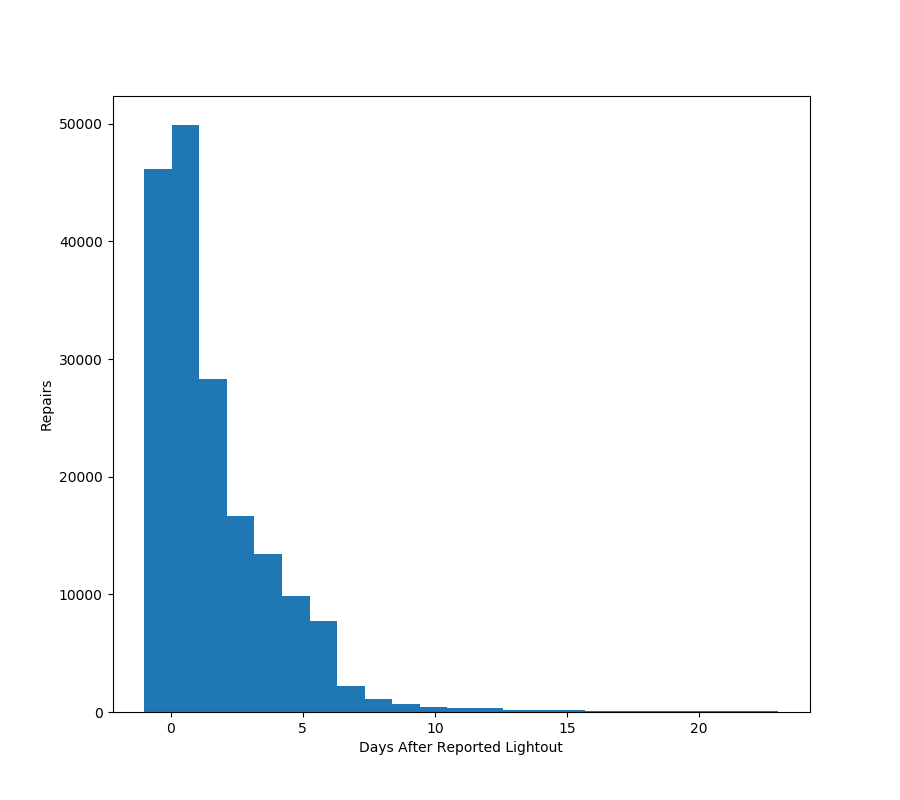

Text(0,0.5,'Repairs')

In [17]:
plt.figure(1)
plt.hist(iSlims['daysToComplete'], bins = 23)
plt.xlabel('Days After Reported Lightout', fontsize=10)
plt.ylabel('Repairs', fontsize=10)

In conclusion with 95% confidence, if we assume lights are randomly assigned (or very nearly randomly assigned), light outages do not likely generally impact crime by any substantial economic margin.  The reason for the null finding of our hypothesis being due to the low overlap between the events of light outages and crime occuring.  This argument is espescially true if it is assumed endogeniety exists and realized that our estimates are larger after subsetting the data in our initial steps.

It should be noted that these findings consider light outages generally across all DC, this is significant because it is quite plausible that any effect supporting our hypothesis is being "drowned out" by the general null effect of light outages generally.  Thus, while we have little empirical motivation, we will attempt to consider some regional and conditional information in the following analysises.

## Light Density Clustering; Random Forest Feature Selection; Difference-in-Difference Analysis
Source: https://python-graph-gallery.com/85-density-plot-with-matplotlib/¶


## Hypothesis:
Different light density clusters across DC will carry different effects for light outages across crime, or more generally, different conditions will exhibit different effects for light outages on crime probabilties.

## Methods:
We will proceed by considering lighting density across DC to get an idea of location.  Then we will use a simple random forest for feature selection to help motivate the essential conditioning factors.  Finally we will use this information across a simple difference-in-difference analysis where we use daylight light outages as a control.  *Note: we will find that daylight outages will prove to be a poor control, so we will proceed by considering individual conditional effects.

First let's take a look at what the denisty of lighting in DC looks like to be sure it measures up to our expectations.

/home/sade/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>


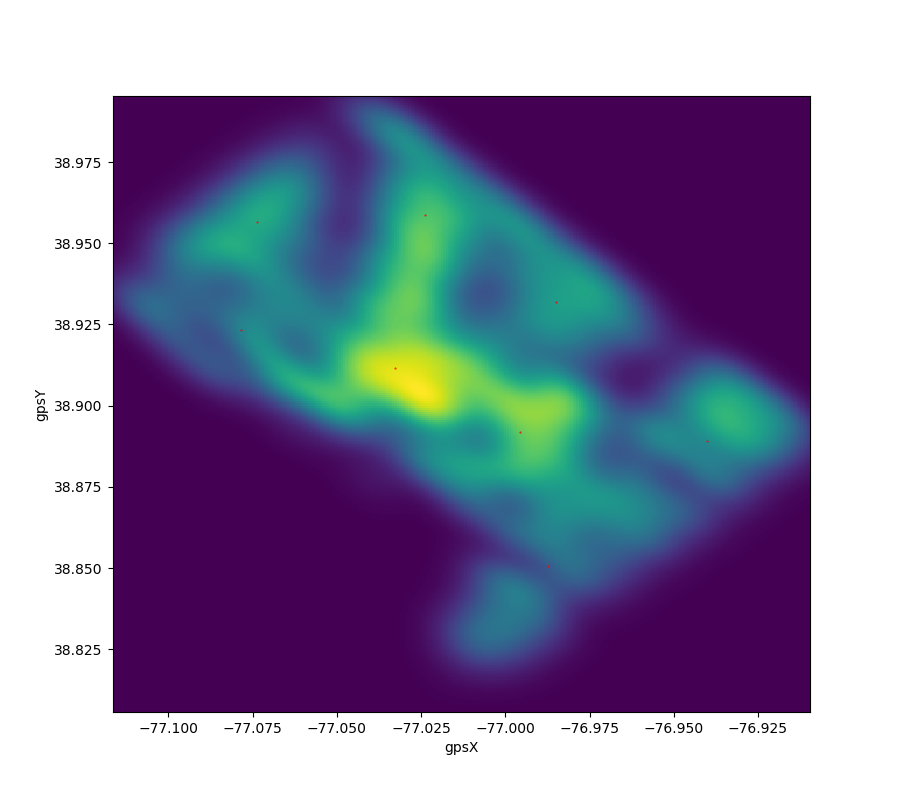

Text(0,0.5,'gpsY')

In [21]:
#Read in datasets
SL = pd.read_csv(choice + '/Street_Lights.csv')
sub_SL = SL[["X","Y"]]

#Fit around street light dataset
kmeans = KMeans(n_clusters=8, random_state=0).fit(sub_SL)
kmeans.cluster_centers_

#place each steet light from L_full to a street light cluster
clusters = kmeans.cluster_centers_
L_full["light_clusters"] = kmeans.predict(L_full.iloc[:,3:5])
x = sub_SL["X"]
y = sub_SL["Y"]

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.figure(8)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.scatter(clusters[:,0], clusters[:,1], s=0.2, c="red")
plt.xlabel('gpsX', fontsize=10)
plt.ylabel('gpsY', fontsize=10)

As one could expect, the density plot above highly refelcts the metropolitan areas of DC.  Further, on the above plot we have mapped out the cluster centeres using k-means that we will use in classification below.

Now considering this information in a random forest for feature selection:

In [ ]:
#Create subset of df called sub_df
cols = ['light_clusters','SLnumberarms','WARD','METHOD','OFFENSE','SHIFT','Crime_LO_intime']
sub_df = L_full[cols]

#Change inputs in sub_df from string values to integers
sub_df = sub_df.replace({"0":0, "1":1, "2":2 })

#Impute values
sub_df = sub_df.replace({'?':1})
sub_df = sub_df.fillna(1)

#Create dummy variables
dummies = pd.get_dummies(sub_df.iloc[:,-4:-1])
dummies = dummies.drop(['METHOD_1','OFFENSE_1', 'SHIFT_1', 'SHIFT_EVENING', 'SHIFT_MIDNIGHT'], axis=1)

#Include dummies in df_final
df_final = pd.concat([sub_df[["light_clusters","SLnumberarms","WARD",'Crime_LO_intime']], dummies], axis=1)

cols = df_final.columns.tolist()

#Rearrange columns
new_cols = cols[:3] + cols[4:] + [cols[3]]

df_final = df_final[new_cols]
df_final = df_final.rename(columns={"light_clusters":"LIGHT_CLUSTER", "SLnumberarms":"NUMBER_OF_ARMS",'Crime_LO_intime':"CRIME_OCCURRED"})

# Get X and y
X = df_final.iloc[:, :-1].values

# Convert 2d array to 1d
y = df_final.iloc[:, -1:].values.ravel()

# Randomly choose 30% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Random forest classifier
rfc = RandomForestClassifier(random_state=0)

# Train the model 
rfc.fit(X_train, y_train)

# Get the feature importances
importances = rfc.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, df_final.columns[:-1])

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

<IPython.core.display.Javascript object>


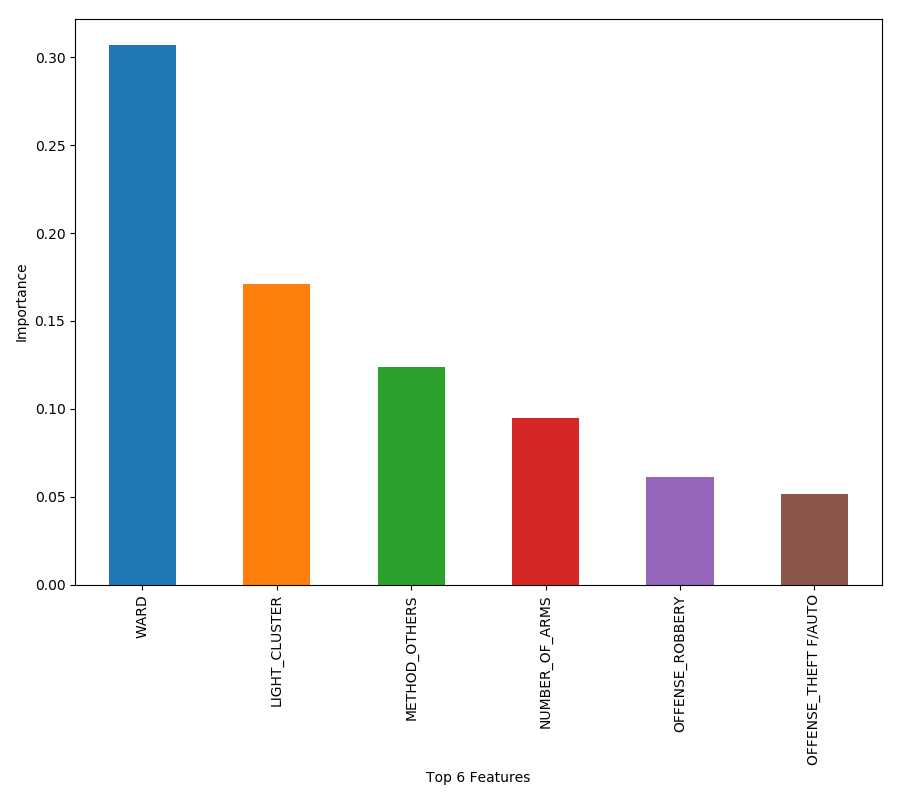

In [270]:
# Make the bar Plot from f_importances 
plt.figure(9)
f_importances[0:6].plot(kind='bar', fontsize=10)
plt.xlabel('Top 6 Features', fontsize=10)
plt.ylabel('Importance', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

The first thing to notice is that "Light_Cluster" is essentially just a poor estimate for Ward.  Thus, we will proceed in a later step looking at some diff-in-diff estimates conditional upon Ward.  The second thing to notice is the importance of the number of arms on a light post, we will discuss those shortly.

In [69]:
# Test the model
y_pred = rfc.predict(X_test)
    
# Get precision, recall, fscore, and support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
    
print('------------------------')
print()
print('Precision, Recall, Fscore, Support: ')
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print()

------------------------

Precision, Recall, Fscore, Support: 
(0.9713685364516719, 0.9713685364516719, 0.9713685364516719, None)



Our prediction precision is exceptionally high, with a roughtly 97% hit ratio.

In [79]:
print("Out of " + str(len(y_pred)) + " observations " + str(int(sum(y_pred))) + " were predicted as 1, the rest are predicted as 0.")

Out of 54730 observations 12 were predicted as 1, the rest are predicted as 0.


However, only 12 observations out of 54,730 were coded as a 1.  This is a classic sparse values problem which is likely due to, as mentioned before, the low overlap between crime and light outage events.

In conclusion, because of the small overlap between events, using random forest for feature selection is not likely to produce reliable results.  Furthermore, we have found that using light clusters to differentiate data is simply a rough estimate of using Wards to differentiate data; thus, we will proceed by investigating only Wards futher.  Also we will investigate the number of arms on a light post because it is the only "important" variable related to lightpost properties.

### Auxiliary Finding:
Light outages do not appear to follow denisty patterning of light posts.

If we consider a similar heat map of light outage density we find a particularly odd clustering of light outages relative to the actual density of streetlights.  Observe the density within the red circle in the density plots below:

The following figure is a denisty plot of street lights in DC.

/home/sade/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>


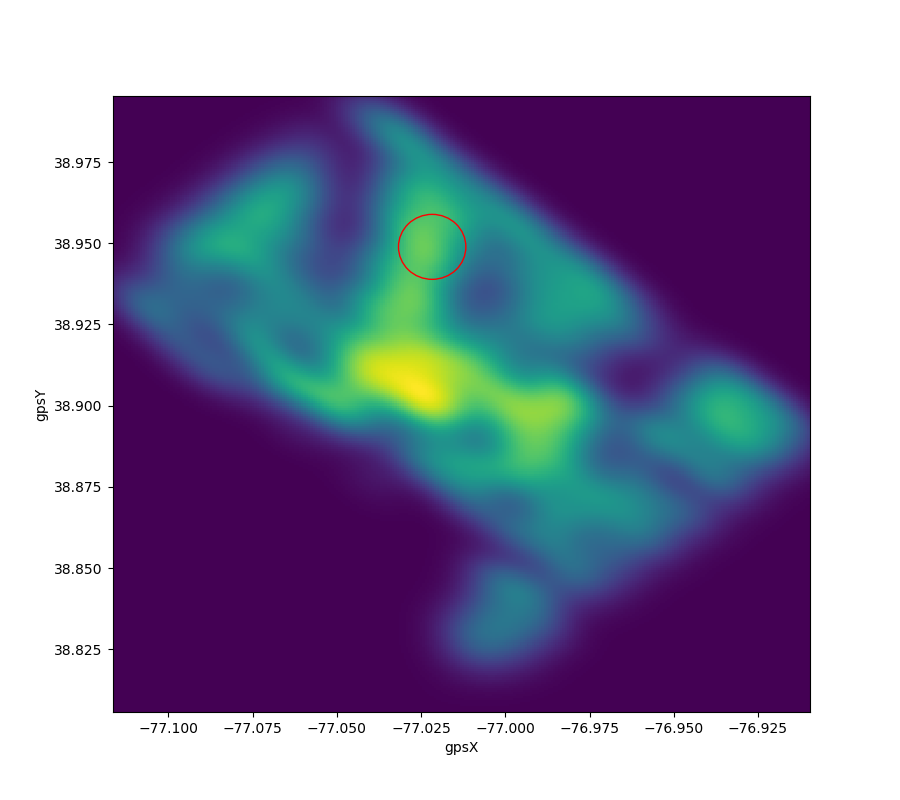

Text(0,0.5,'gpsY')

In [22]:
#Read in datasets
SL = pd.read_csv(choice + '/Street_Lights.csv')
sub_SL = SL[["X","Y"]]

#Fit around street light dataset
kmeans = KMeans(n_clusters=8, random_state=0).fit(sub_SL)
kmeans.cluster_centers_

#place each steet light from L_full to a street light cluster
clusters = kmeans.cluster_centers_
L_full["light_clusters"] = kmeans.predict(L_full.iloc[:,3:5])
x = sub_SL["X"]
y = sub_SL["Y"]

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.figure(10)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.gca().add_artist(plt.Circle((-77.0217, 38.9489), 0.01, color='r', fill=False))
plt.xlabel('gpsX', fontsize=10)
plt.ylabel('gpsY', fontsize=10)

The following figure is a density plot of street light outages in DC.

<IPython.core.display.Javascript object>


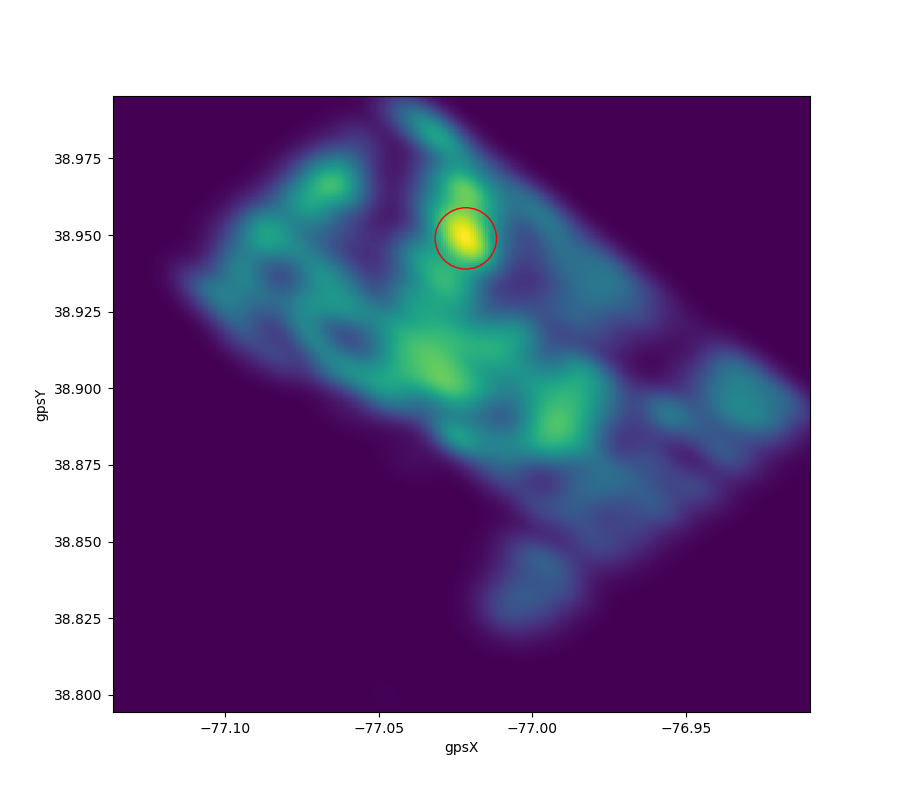

Text(0,0.5,'gpsY')

In [29]:
#%% Auxiliary Finding of interest: Light outages do not follow denisty patterning of Light posts
sub_lights = Lights[["gpsX","gpsY"]]

x = sub_lights["gpsX"]
y = sub_lights["gpsY"]

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.figure(11)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.gca().add_artist(plt.Circle((-77.0217, 38.9489), 0.01, color='r', fill=False))
plt.xlabel('gpsX', fontsize=10)
plt.ylabel('gpsY', fontsize=10)

Notice how these two plots compare.  The first plot shows us the density of streetlights in DC, while the second plot shows us the density of lightoutages in DC.  In theory both of these plots should be roughly the same under the assumption that lightoutages are randomly distributed (and this is true generally as can be seen in the area outside the red circle); however, there is a striking violation to this rule in the above red circle.

It is important to note these density plots are relitive to the differential within each plot; therefore, what matters is that these plots should be relatively similar under the assumption that light outages are a random occurance.  Such a "hot" area in the second circle relative to the first circle represents an anomaly.

We will take one more side course and consider the timing of the light outages within this red circle to see if they all went out around a similar time (denoting perhaps a bad batch of light bulbs that were all installed at once and went out around a similar time) or if the outages above occured randomly across the sampled timeframe.

In [25]:
mask = (Lights['gpsX'] <= -77.0117) & (Lights['gpsX'] >= -77.0317) & (Lights['gpsY'] >= 38.9389) & (Lights['gpsY'] <= 38.9589)
dLights = Lights[mask]['WoCompleted'].dropna()
nLights = Lights['WoCompleted'].dropna()

<IPython.core.display.Javascript object>


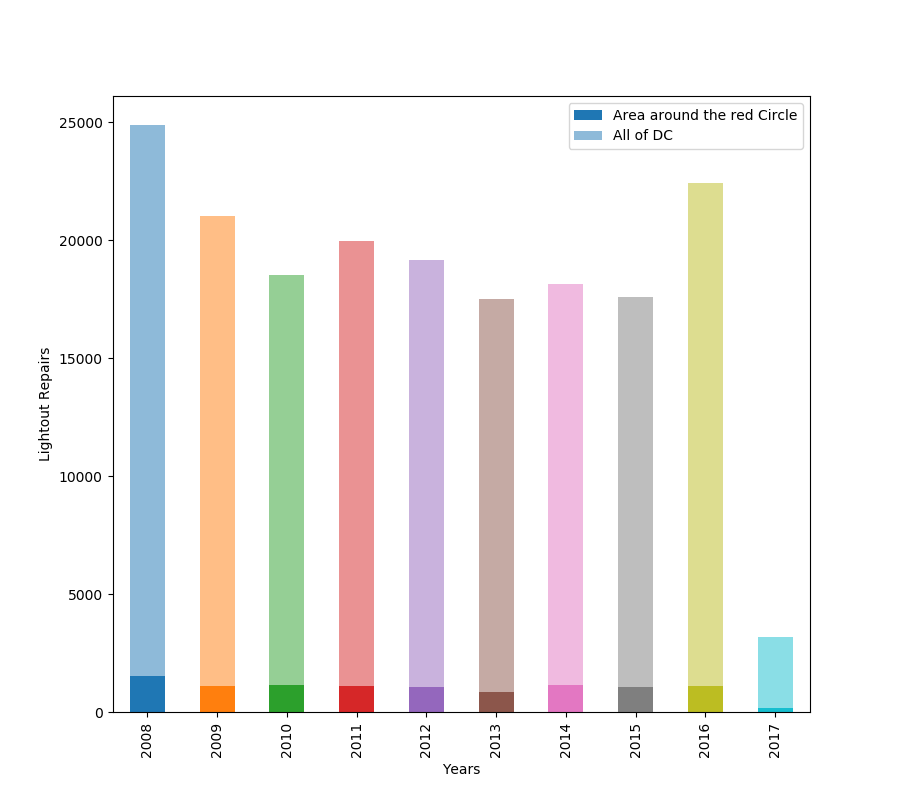

In [282]:
plt.figure(12)
per = dLights.dt.to_period('Y')
gd = dLights.groupby(per).count()
gd.plot(kind = "bar", fontsize=10, label = "Area around the red Circle")
per = nLights.dt.to_period('Y')
gn = nLights.groupby(per).count()
gn.plot(kind = "bar", fontsize=10, alpha=.5, label = "All of DC")
plt.xlabel('Years', fontsize=10)
plt.ylabel('Lightout Repairs', fontsize=10)
plt.legend(loc = 'best')

In [265]:
np.corrcoef(gd, gn)[1,0]

0.9441937475676248

As can be seen above, the light outages around the "hot spot" do seem to occur purportionally across years.  Furthermore, the correlation across years is very high.  This implies that the light outages in this "hot spot" have no unusual patterns.

Just to be sure let's break the same information down by month and take a look at our correlation. Note: the correlation at this level of fidelity should decrease; however, we would expect it to still be moderately to high (.60 - .90).

<IPython.core.display.Javascript object>


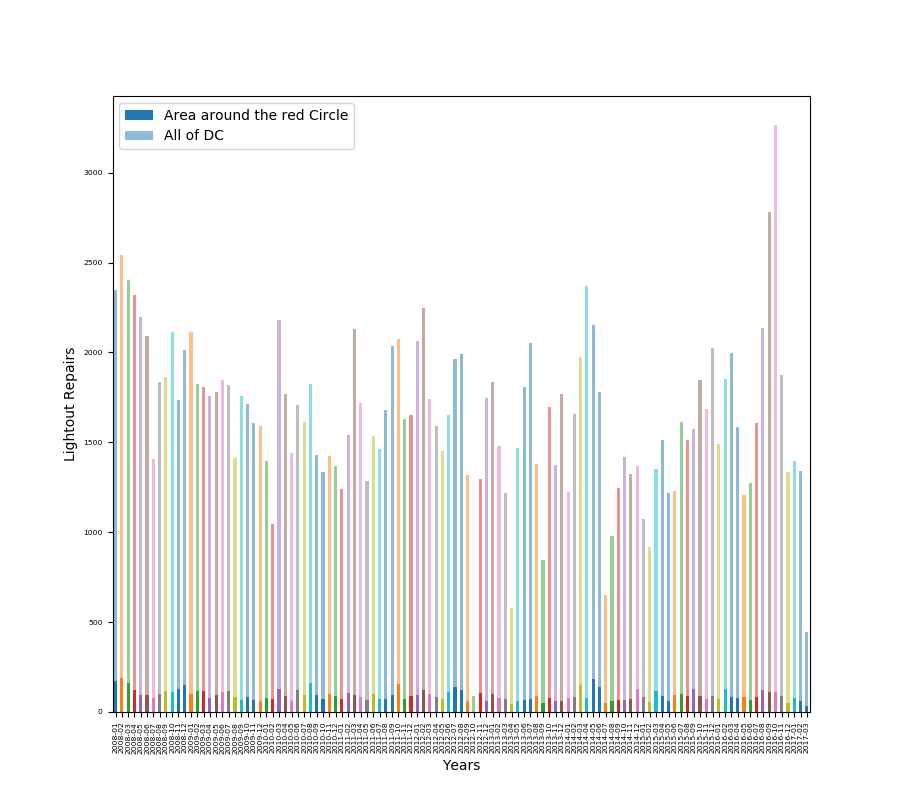

In [281]:
plt.figure(13)
per = dLights.dt.to_period('M')
gd = dLights.groupby(per).count()
gd.plot(kind = "bar", fontsize=5.5, label = "Area around the red Circle")
per = nLights.dt.to_period('M')
gn = nLights.groupby(per).count()
gn.plot(kind = "bar", fontsize=5.5, alpha = .5, label = "All of DC")
plt.xlabel('Years', fontsize=10)
plt.ylabel('Lightout Repairs', fontsize=10)
plt.legend(loc = 'best')

Side observation:  It looks like this data exhibits strong seasonality.  This may be of interest as it provides insight into when light outages will occur.

In [275]:
np.corrcoef(gd, gn)[1,0]

0.6776017114949331

The correlation is still moderately high and we find evidece to suggest that there is something about this area causing light outages to be non-random in our data.  This warrants further future investigation.  In closing, here are a few closer looks at the "hot" area (which consists of BrightWood Park and Petworth) and Lightout repairs by month (to help illuminate the seasonality that exists).

<IPython.core.display.Javascript object>


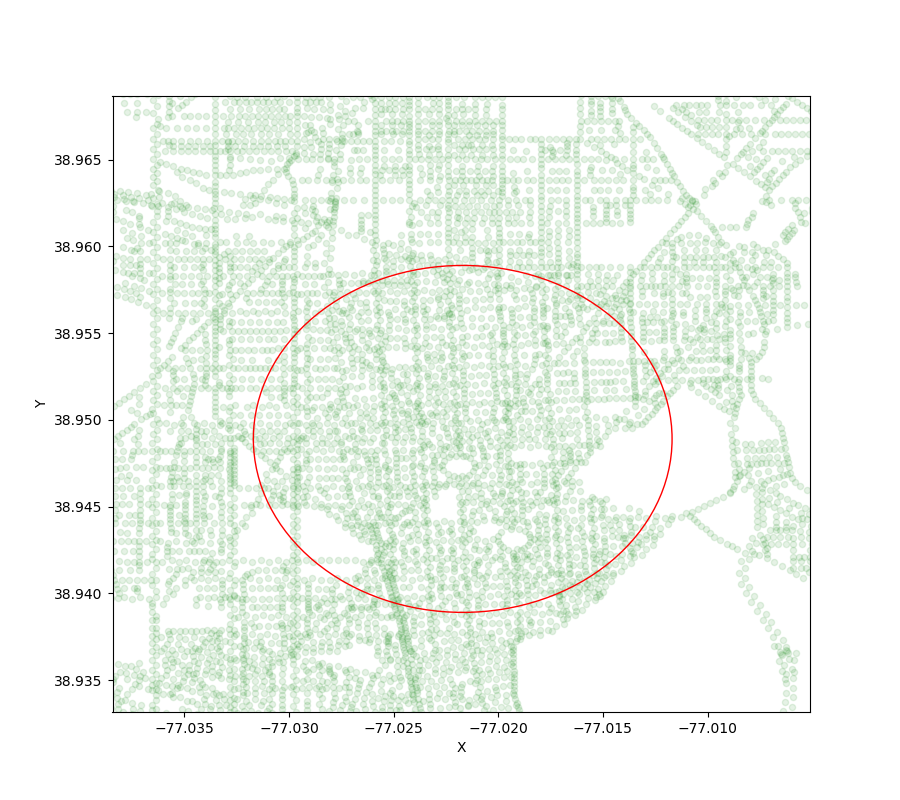

<IPython.core.display.Javascript object>


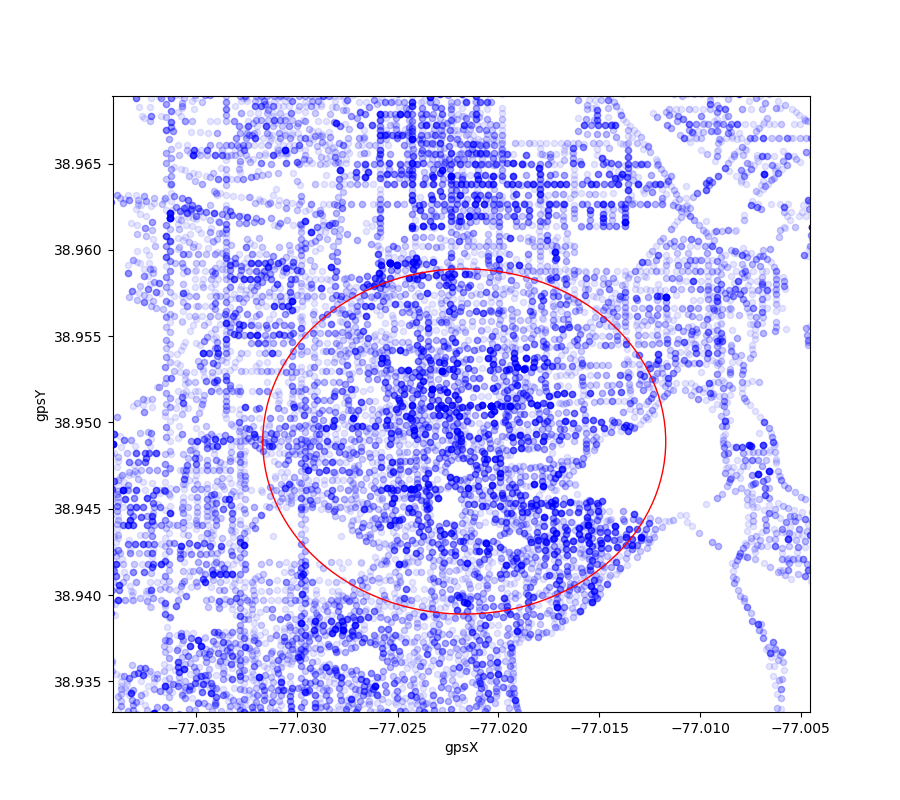

In [292]:
SL[["X","Y"]].plot(kind = "scatter", x = "X", y = "Y", alpha = .1, color = "green")
plt.gca().add_artist(plt.Circle((-77.0217, 38.9489), 0.01, color='r', fill=False))
Lights[["gpsX","gpsY"]].plot(kind = "scatter", x = "gpsX", y = "gpsY", alpha = .1, color = "blue")
plt.gca().add_artist(plt.Circle((-77.0217, 38.9489), 0.01, color='r', fill=False))

<IPython.core.display.Javascript object>


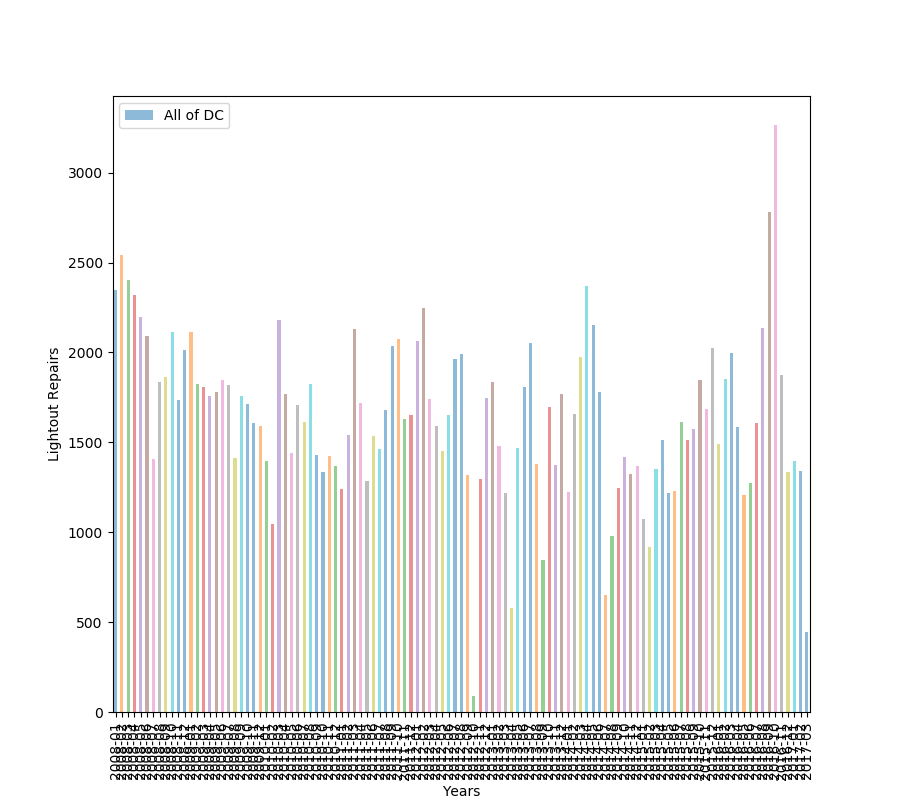

In [28]:
plt.figure(16)
per = nLights.dt.to_period('M')
gn = nLights.groupby(per).count()
gn.plot(kind = "bar", fontsize=10, alpha=.5, label = "All of DC")
plt.xlabel('Years', fontsize=10)
plt.ylabel('Lightout Repairs', fontsize=10)
plt.legend(loc = 'best')

## Results:

In [293]:
# Setting up geo joined data for day hours
# geoLights0 is a df of light outages and crimes that did not happen in a 10 day window
# geoLights1 is a df of light outages and crimes that happened in a 10 day window
DL_noCR = pd.read_excel(choice + '/geoDLights0.xlsx')
DL_noCR = DL_noCR.reset_index(drop = True)
DL_yesCR_dup = pd.read_excel(choice + '/geoDLights1.xlsx')
DL_yesCR_dup = DL_yesCR_dup.reset_index(drop = True)
# Be advised there is some small cross over between L_noCR and L_yesCR_dup

# Pulling out all the duplicate crimes into a side dataframe
DL_yesCR_dup_only = DL_yesCR_dup[DL_yesCR_dup.duplicated(['WoID'], keep = False)]
DL_yesCR_dup_only = DL_yesCR_dup_only.reset_index(drop = True)

# Making a data set that treats multiple crimes at the same time/ place as one
DL_yesCR_nodup = DL_yesCR_dup[~DL_yesCR_dup.duplicated(['WoID'], keep = 'first')]
DL_yesCR_nodup = DL_yesCR_nodup.reset_index(drop = True)

#%% Merging and setting up final dataset

# Pulling out unmatched observations
DL_0_1 = pd.concat([DL_noCR, DL_yesCR_nodup]) # With overlap
DL_temp = DL_0_1[DL_0_1.duplicated(['WoID'], keep = False)]
DL_0_1 = DL_0_1[~DL_0_1.duplicated(['WoID'], keep = False)]
DL_temp = DL_temp[DL_temp['Crime_LO_intime'] == 1]
DL_0_1 = pd.concat([DL_0_1, DL_temp]) # Without overlap

# Final dataset
DL_full = pd.merge(Lights, DL_0_1, how = 'left', on = 'WoID')
DL_full = DL_full.drop(['WoEntered_y', 'WoCompleted_y', 'gpsX_y', 'gpsY_y'], axis = 1)
DL_full = DL_full.rename(columns={'gpsX_x':'gpsX', 'gpsY_x':'gpsY', 'WoEntered_x':'WoEntered', 'WoCompleted_x':'WoCompleted', 'X':'gpsX_CR', 'Y':'gpsY_CR'})
DL_full['Crime_LO_intime'][np.isnan] = 0

/home/sade/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [294]:
DL_full['CR_Before_Fix'] = 0
for i in DL_full[DL_full['Crime_LO_intime'] == 1].index:
    if (DL_full.loc[i, 'WoCompleted'] - DL_full.loc[i, 'REPORT_DAT']).days >= 0 and (DL_full.loc[i, 'WoCompleted'] - DL_full.loc[i, 'REPORT_DAT']).days <= 10:
        DL_full.loc[i, 'CR_Before_Fix'] = 1
DL_full['CR_After_Fix'] = 0
for i in DL_full[DL_full['Crime_LO_intime'] == 1].index:
    if (DL_full.loc[i, 'WoCompleted'] - DL_full.loc[i, 'REPORT_DAT']).days < 0 and (DL_full.loc[i, 'WoCompleted'] - DL_full.loc[i, 'REPORT_DAT']).days >= -10:
        DL_full.loc[i, 'CR_After_Fix'] = 1

In [305]:
Dmeandif = sum(DL_full['CR_Before_Fix'])/len(DL_full) - sum(DL_full['CR_After_Fix'])/len(DL_full)
print("Day mean difference:   " + str(Dmeandif))
print("Night mean difference: " + str(meandif))

Day mean difference:   0.003245044728994912
Night mean difference: 0.00115111383967725


Interestingly the day-mean-difference effect is actually larger than the night-mean-difference effect.  There are two possible reasons for this: either lights going out actually reduce crime (unlikely), or there is something wrong with our estimates.  Considering that these estimates are anchored around the repair date and that repairs happen during the day, it's likely that we are witnessing a very small bias for the day mean difference (said differently: the repair of the light likely causes crime to be slightly less probable, biasing the control).  Therefore, it is likely that day crimes are a poor control.  We will proceed without any further Diff-in-Diff estimates and simply consider conditional means.

In [419]:
L_fullA = L_full

In [420]:
Arms = pd.get_dummies(L_full['SLnumberarms'])
L_fullA['one_arm'] = Arms[0]+Arms[1]
L_fullA['two_arm'] = Arms[2]

In [421]:
print("Number of 2 armed light poles:          " + str(sum(Arms[2])))
print("Number of 1 or 0 armed light poles:     " + str(sum(Arms[0]+Arms[1])))
print("Ratio of 2 armed light poles to others: " + str(sum(Arms[2])/sum(Arms[0]+Arms[1])))

Number of 2 armed light poles:          649
Number of 1 or 0 armed light poles:     181783
Ratio of 2 armed light poles to others: 0.0035701908319259778


There are so few two armed light posts that an analysis here will likely exhibit a sparse values problem; however, we will go ahead and look at the difference between conditional means.  This result should be insignificant given the sample size is relatively small and there should, in theory, be no mean difference among light posts with more than one arm.

In [422]:
Ameandif = sum(L_fullA[L_fullA['two_arm'] == 1]['CR_Before_Fix'])/sum(L_fullA['two_arm']) - (sum(L_fullA[L_fullA['two_arm'] == 1]['CR_After_Fix'])/sum(L_fullA['two_arm']))
print("Mean difference: " + str(Ameandif))
VarB = sum(L_fullA[L_fullA['two_arm'] == 1]['CR_Before_Fix'])/sum(L_fullA['two_arm'])*(1 - sum(L_fullA[L_fullA['two_arm'] == 1]['CR_Before_Fix'])/sum(L_fullA['two_arm']))
VarA = sum(L_fullA[L_fullA['two_arm'] == 1]['CR_Before_Fix'])/sum(L_fullA['two_arm'])*(1 - sum(L_fullA[L_fullA['two_arm'] == 1]['CR_Before_Fix'])/sum(L_fullA['two_arm']))
Sdif = np.sqrt((VarB/sum(L_fullA['two_arm']))+(VarA/sum(L_fullA['two_arm'])))
t = Ameandif/Sdif
print("T-score:         " + str(t))

Mean difference: -0.0015408320493066271
T-score:         -0.19811032780637944


As expected the two armed light posts do not exhibit a statistically significant estimate.  Given this estimate is insignificant and that the actual instances before and after a streetlight repair being considered here are so small numerically here, we can conclude the number of arms is not impacting our prior results in a significant way.  Below are the counts of instances being considered:

In [423]:
print("Before: "+ str(sum(L_fullA[L_fullA['two_arm'] == 1]['CR_Before_Fix'])))
print("After:  " + str(sum(L_fullA[L_fullA['two_arm'] == 1]['CR_After_Fix'])))

Before: 13
After:  14


Finally let's consider Wards and Types of crimes as a last extension of our questioning.

In [427]:
Wards = pd.get_dummies(L_fullA['WARD'])
Wards.rename(columns = {1:'W_One', 2:'W_Two', 3:'W_Three', 4:'W_Four', 5:'W_Five', 6:'W_Six', 7:'W_Seven', 8:'W_Eight' }, inplace = True)

In [429]:
L_fullA = pd.concat([L_fullA, Wards], axis = 1)
L_fullA = L_fullA.reset_index(drop=True)
L_fullA.rename(columns = {1:'W_One', 2:'W_Two', 3:'W_Three', 4:'W_Four', 5:'W_Five', 6:'W_Six', 7:'W_Seven', 8:'W_Eight' }, inplace = True)

In [432]:
for i in list(Wards.columns):
    try:
        Ameandif = sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i]) - (sum(L_fullA[L_fullA[i] == 1]['CR_After_Fix'])/sum(L_fullA[i]))
        VarB = sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i])*(1 - sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i]))
        VarA = sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i])*(1 - sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i]))
        Sdif = np.sqrt((VarB/sum(L_fullA[i]))+(VarA/sum(L_fullA[i])))
        t = Ameandif/Sdif
        print(i + ':' + str(round(Ameandif, 5)) + ', t: ' + str(t))
    except:
        print('problem')
        pass

W_One: 0.00273, t: 0.9738079825243195
W_Two: 0.00456, t: 2.3906704133448144
W_Three: 0.00026, t: 0.2841634917606786
W_Four: 0.00119, t: 1.2810260775482374
W_Five: 0.00087, t: 0.6618749634662113
W_Six: 0.00111, t: 0.8335134813544995
W_Seven: 0.00141, t: 1.020648820756218
W_Eight: 0.00069, t: 0.3226726145892822


Only the effect for Ward 2 exhibits statisticaly significance (this is likely due to the fact that the majority of crimes are located in Ward 2) and the estimate is still very small.  In conclusion, conditioning on Ward does not appear to show any economically significant effect.

In [433]:
Crimes = pd.get_dummies(L_fullA['OFFENSE'])

In [434]:
L_fullA = pd.concat([L_fullA, Crimes], axis = 1)
L_fullA = L_fullA.reset_index(drop=True)

In [436]:
for i in list(Crimes.columns):
    try:
        Ameandif = sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i]) - (sum(L_fullA[L_fullA[i] == 1]['CR_After_Fix'])/sum(L_fullA[i]))
        VarB = sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i])*(1 - sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i]))
        VarA = sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i])*(1 - sum(L_fullA[L_fullA[i] == 1]['CR_Before_Fix'])/sum(L_fullA[i]))
        Sdif = np.sqrt((VarB/sum(L_fullA[i]))+(VarA/sum(L_fullA[i])))
        t = Ameandif/Sdif
        print(i + ': ' + str(round(Ameandif, 5)) + ', t: ' + str(t))
    except:
        print('problem')
        pass

ARSON: 0.0, t: 0.0
ASSAULT W/DANGEROUS WEAPON: 0.00128, t: 0.7887988642545403
BURGLARY: 0.00158, t: 1.0343404144549218
HOMICIDE: 0.00527, t: 1.1186895349737676
MOTOR VEHICLE THEFT: -8e-05, t: -0.05209749187566891
ROBBERY: 0.00185, t: 1.5203421729049702
SEX ABUSE: 0.00111, t: 0.26037292943499846
THEFT F/AUTO: 0.00265, t: 2.4904962079590907
THEFT/OTHER: 0.00082, t: 0.5855406750801618


Here only the effect for auto theft is significant (again this is likely due to the fact that the majority of crimes are auto thefts excluding the catch all category "other") and the estimate is again still very small.  In conclusion, condition on type of crime does not appear to show any economically significant effect.

In summary, again we find that, due to the low overlap between light outages and crimes events, we were not able to produce evidence to support that light outages affect crimes under these specific individual conditions: Wards, Crime Types, and Number of Arms.  Therefore, for the given data we have considered under the conditions we have considered, light outages do not affect crime with economic significance.

## Recommendations:

Considering our analyses produce null results, our findings support the conclusion that individual light outages, generally and given the regulation considering repair times, do not impact the probability of a crime occuring.  Furthermore, we have also considered several conditional cases that also support the same conclusion under these conditions.  Therefore, we find that the policy of light replacement is adequate to supress crime under the assumption that a light outage, if left unreplaced for long enough, would increase the probability of a crime occuring.  Furthermore under the same previous assumption, it may be possible to extend the allowed deadline for light outage replacement and not impact crime rates if there is an economic justification for doing so.<br>

As per our auxiliary finding,  we recommend further inquiry into light outages in the areas of BrightWood Park and Petworth.  Looking at the data there is not yet a clear reason why such a high denisty of light outages occur in this area.  Furthermore, it may be of interest to consider the seasonal affects of light outages as the data highly implies seasonality effects are significant.